## Introduction to Vision: Exploring Images and Building a Simple Vision Pipeline


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, data, exposure, transform, filters, util, metrics
import cv2
from scipy.signal import convolve2d

print("Library versions:")
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("cv2:", cv2.__version__)



Library versions:
numpy: 2.1.3
matplotlib: 3.10.1
cv2: 4.12.0


## A. Background ##

Brief overview of the challenge of computer vision and simple vision systems


To understand why computer vision is challenging, we can apply transformations that change how an image looks:  
- **Rotation**: simulates different viewpoints  
- **Scaling (resizing)**: changes the object size  
- **Noise**: simulates sensor imperfections or poor quality


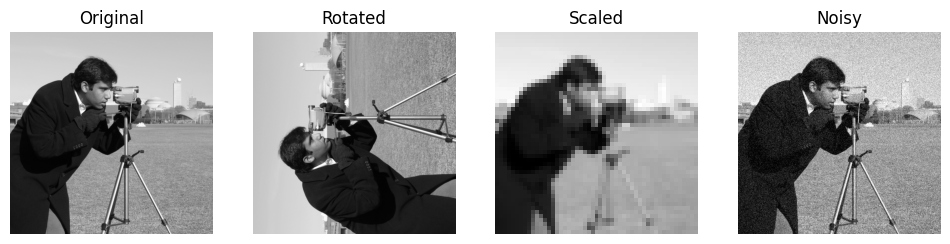

In [2]:
image = data.camera()


# --- Create variations --- 

# rotated
rotated = transform.rotate(image, 90)

# rescale
scaled = transform.rescale(image, 0.1, anti_aliasing=True)

# random_noise
noisy = util.random_noise(image)

# --- Show images --- 
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
titles = ['Original', 'Rotated', 'Scaled', 'Noisy']
imgs = [image, rotated, scaled, noisy]

for ax, img, title in zip(axes, imgs, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

**Simple Vision Systems**: Edge Detection

One of the simplest vision techniques is **edge detection**, where we highlight boundaries in an image.  
Edges are places where pixel intensity changes quickly — often corresponding to object outlines or texture.  
Here we use the **Sobel filter** from `skimage.filters` to compute edges.


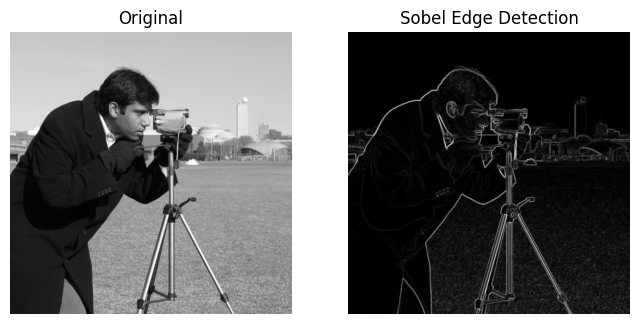

In [3]:

# Apply Sobel filter to detect edges
edges = filters.sobel(image)

# Plot original image vs. edges
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
# Show original
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original")
ax[0].axis("off")

# Show detected edges
ax[1].imshow(edges, cmap='gray')
ax[1].set_title("Sobel Edge Detection")
ax[1].axis("off")

plt.show()

Template Matching

Template matching is a classical computer vision technique where a **small patch (template)** is slid over an image to find the best matching location.  
It works well when the object appears exactly as in the template, but struggles with scale, rotation, or noise.


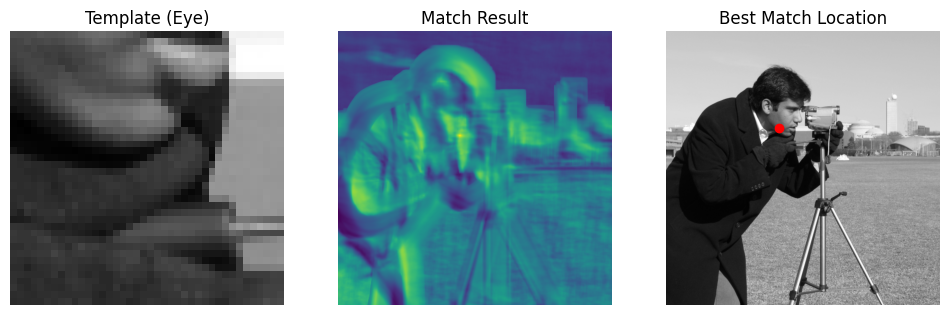

In [4]:
from skimage.feature import match_template
import matplotlib.pyplot as plt
import numpy as np

# --- Step 1: Extract a template (a patch of the original image) ---
# Here we take a region around the eye as our template
template = image[180:220, 210:250]

# --- Step 2: Perform template matching ---
# The function slides the template across the image and returns similarity scores
result = match_template(image, template)

# --- Step 3: Find the best match location (highest similarity score) ---
ij = np.argmax(result)
x, y = np.unravel_index(ij, result.shape)

# --- Step 4: Visualize the process ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

# Show the template (eye patch)
ax1.imshow(template, cmap='gray')
ax1.set_title("Template (Eye)")
ax1.axis("off")

# Show the similarity map (high values = good match)
ax2.imshow(result, cmap='viridis')
ax2.set_title("Match Result")
ax2.axis("off")

# Show the best match location on the original image
ax3.imshow(image, cmap='gray')
ax3.plot(y, x, 'ro')  # red dot marks best match
ax3.set_title("Best Match Location")
ax3.axis("off")

plt.show()

## B. Loading and Displaying Images ##

Before applying transformations, it’s important to **load an image** and check its properties.  
We’ll use the `astronaut` sample from `skimage.data` and print details such as shape, data type, and intensity range.


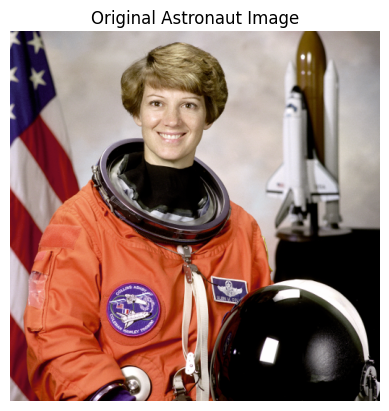

{'shape': (512, 512, 3), 'dtype': dtype('uint8'), 'range': (np.uint8(255), np.uint8(0))}


In [5]:
# --- Load example image from scikit-image's built-in dataset ---
img = data.astronaut()

# --- Display the image ---
plt.imshow(img)
plt.title("Original Astronaut Image")
plt.axis("off")
plt.show()

# --- Define a helper function to describe basic image properties ---
def describe(img):
    return {
        "shape": img.shape, # dimensions: (rows, cols, channels)
        "dtype": img.dtype, # data type (e.g., uint8, float32)
        "range": (img.max(), img.min())  # min/max intensity values
    }

# --- Print the image description ---
print(describe(img))

## C. Inspecting Pixel Data ##

Digital images are stored as arrays of pixel values.  
It is often useful to inspect an image’s **shape**, **data type**, and **intensity range** before applying any processing steps.  
This helps us understand the image representation and avoid errors later.


Most images are stored in the **RGB color space** (Red, Green, Blue channels).  
Sometimes we convert them into **grayscale** (single intensity channel), especially when color is not important for the task.  
Here we compare the original RGB image with its grayscale version and implement our own `rgb_to_gray` conversion using standard luminance weights.


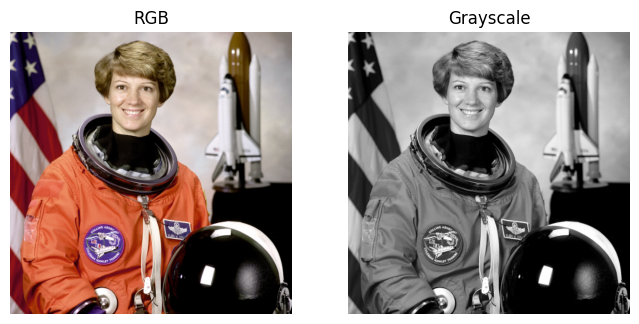

Gray difference: 0.01075637764126645


In [6]:
from skimage import color
import matplotlib.pyplot as plt
import numpy as np

# --- Convert the image to grayscale using skimage ---
img_gray = color.rgb2gray(img)

# --- Display the original (RGB) and grayscale versions side by side ---
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].imshow(img)
ax[0].set_title("RGB")
ax[0].axis("off")

ax[1].imshow(img_gray, cmap='gray')
ax[1].set_title("Grayscale")
ax[1].axis("off")

plt.show()

# --- Define a manual RGB → Grayscale conversion ---
def rgb_to_gray(input_img):
    # Check that the image has 3 channels
    assert input_img.shape[2] == 3, "The input image must have 3 channels"

    # Split into R, G, B channels    
    r, g, b = input_img[:,:,0], input_img[:,:,1], input_img[:,:,2]

    # Weighted sum according to luminance perception
    weighted_sum = 0.299*r + 0.587*g + 0.114*b
    
    return weighted_sum

# --- Compare the manual conversion with skimage's version ---
difference = np.abs(rgb_to_gray(img) / 255.0 - color.rgb2gray(img)).mean()
print("Gray difference:", difference)


Digital images are represented as discrete samples (pixels) with discrete intensity values.  

- **Sampling** controls the *spatial resolution* (number of pixels).  
- **Quantization** controls the *intensity resolution* (number of values per pixel).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


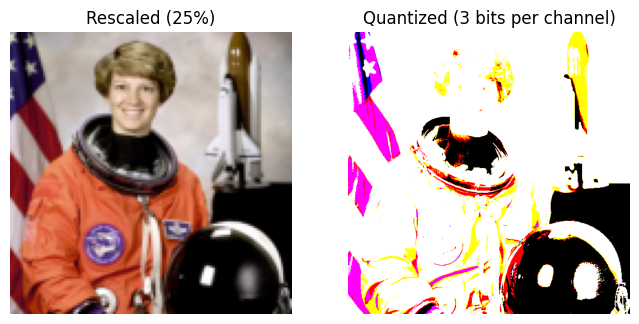

In [7]:
from skimage import transform
import matplotlib.pyplot as plt
import numpy as np

# --- Downsample the image to 25% of its original size ---
img_small = transform.rescale(img, 0.25, channel_axis=-1, anti_aliasing=True)

# --- Define a quantization function ---
def quantize(input_img, bits):
    assert input_img.shape[2] == 3, "The input image must have 3 channels"
    
    # Normalize pixel values to [0, 1]
    img_f = input_img/255
    
    # Number of intensity levels given the bit depth
    levels = 2**bits
    
    # Quantize by mapping values into discrete bins
    q = np.round(img_f*(levels -1))/(levels -1)
    
    # Scale back to [0, 255] and convert to uint8
    out_img = q*255
    
    return out_img

# --- Visualize sampling and quantization effects ---
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# Show rescaled (downsampled) image
ax[0].imshow(img_small)
ax[0].set_title("Rescaled (25%)")
ax[0].axis("off")

# Show quantized image (3 bits per channel)
ax[1].imshow(quantize(img, 3))
ax[1].set_title("Quantized (3 bits per channel)")
ax[1].axis("off")

plt.show()

A **point operation** modifies pixel values independently (e.g., brightness adjustment, contrast stretching).  
Histograms help us understand the distribution of pixel intensities across channels.  
Here we visualize the **RGB histograms** of the astronaut image to see how pixel values are spread.


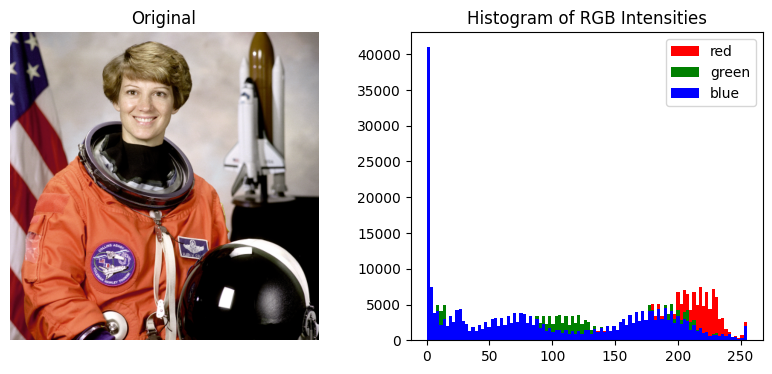

In [8]:
import matplotlib.pyplot as plt

# --- Create figure with two subplots: original image + histogram ---
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# --- Show original image ---
ax[0].imshow(img)
ax[0].axis("off")
ax[0].set_title("Original")

# --- Plot RGB histograms ---
colors = ['red', 'green', 'blue']
for i, color in enumerate(colors):
    # Flatten the channel (ravel) and plot histogram
    ax[1].hist(img[:, :, i].ravel(), bins=100, label=color, color=color)

ax[1].set_title("Histogram of RGB Intensities")
ax[1].legend()

plt.show()

Gamma correction is a nonlinear **point operation** used to adjust image brightness.  
It is especially important because display devices (monitors, cameras) often apply gamma encoding.  
Here we implement a gamma correction function and apply it with $\gamma = 2.2$, which darkens the mid-tones.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


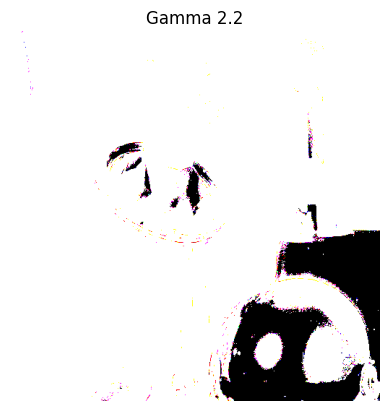

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define a gamma correction function ---
def gamma_correct(input_img, gamma):
    assert input_img.shape[2] == 3, "The input image must have 3 channels"
    
    # Normalize pixel values to [0, 1]
    img_f = input_img/255
    
    # Apply gamma correction: output = input^(1/gamma)
    corrected = img_f**(1/gamma)
    
    # Scale back to [0, 255] and convert to uint8
    out_img = corrected*255
    
    return out_img

# --- Apply gamma correction with γ = 2.2 ---
plt.imshow(gamma_correct(img, 2.2))
plt.title("Gamma 2.2")
plt.axis("off")
plt.show()


## D. Image Manipulations ##

Grayscale conversion, contrast enhancement, cropping, resizing. Visualising the impact of transformations.


Many vision tasks do not require color information.  
Converting an image from **RGB (3 channels)** to **grayscale (1 channel)** simplifies computations while preserving structural details like edges and textures.  
Here we compare the original image with its grayscale version.


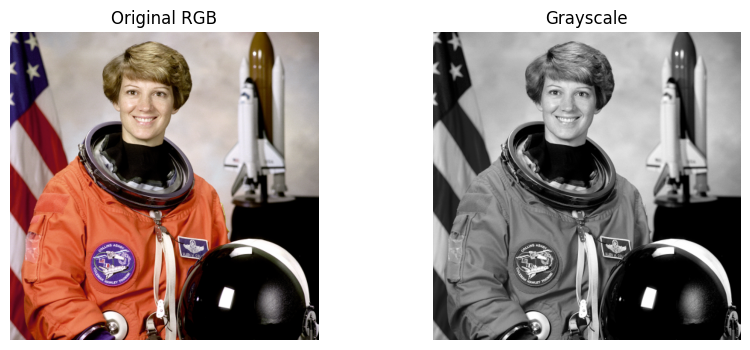

In [10]:
from skimage import color

# --- Convert the RGB image to grayscale ---
gray_image = color.rgb2gray(img)

# --- Display the original RGB and grayscale images side by side ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img)                   # show original color image
axes[0].set_title("Original RGB")
axes[0].axis("off")

axes[1].imshow(gray_image, cmap="gray")  # show grayscale image
axes[1].set_title("Grayscale")
axes[1].axis("off")

plt.show()


Histogram equalization is a technique to improve image **contrast**.  
It redistributes pixel intensities so that they cover the full available range more evenly.  
This can make details more visible, especially in low-contrast images.  
Here we apply histogram equalization to a grayscale image and compare both the image and its pixel distributions.


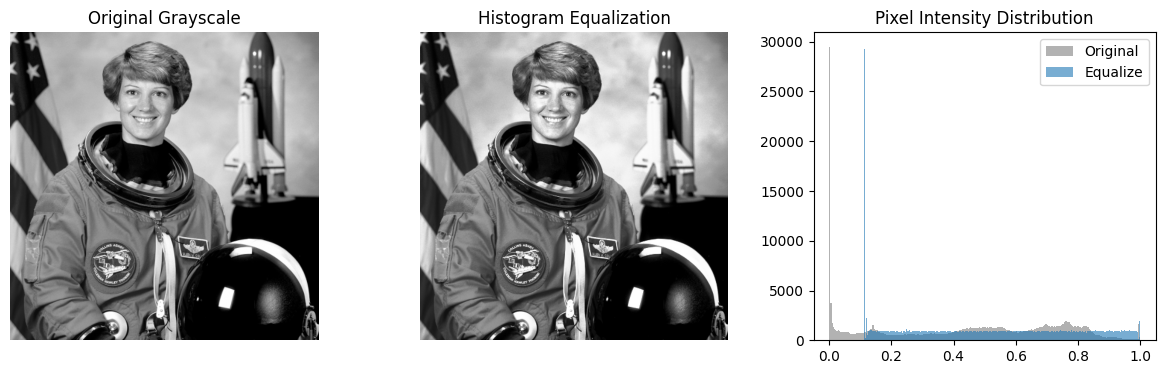

In [11]:
# --- Apply histogram equalization to the grayscale image ---
equalized = exposure.equalize_hist(gray_image)

# --- Create subplots: original, equalized, and histograms ---
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Show original grayscale image
axes[0].imshow(gray_image, cmap="gray")
axes[0].set_title("Original Grayscale")
axes[0].axis("off")

# Show equalized grayscale image
axes[1].imshow(equalized, cmap="gray")
axes[1].set_title("Histogram Equalization")
axes[1].axis("off")

# Plot histograms of pixel intensities before and after equalization
axes[2].hist(gray_image.ravel(), bins=256, color='gray', alpha=0.6, label="Original")
axes[2].hist(equalized.ravel(), bins=256, alpha=0.6, label="Equalize")

axes[2].set_title("Pixel Intensity Distribution")
axes[2].legend()

plt.show()

Cropping is a basic image manipulation used to **focus on a specific area** of interest.  
This can reduce irrelevant background, simplify processing, and improve performance for downstream tasks.  
Here we crop a region containing the astronaut's face.


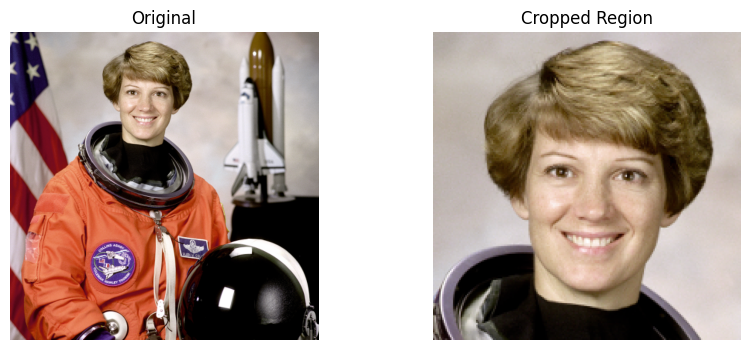

In [12]:
import matplotlib.pyplot as plt

# --- Crop a region of interest from the original image ---
# Here we select rows 10 to 210 and columns 120 to 320
crop = img[10:210, 120:320]

# --- Display the original image and the cropped region side by side ---
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(img)              # show original image
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(crop)             # show cropped image
axes[1].set_title("Cropped Region")
axes[1].axis("off")

plt.show()

Resizing adjusts the **spatial resolution** of an image.  
- **Downsampling** reduces image size, which can save computation but may lose details.  
- **Upsampling** increases image size, which can introduce blurring or pixelation.  
Here we resize a cropped region to a smaller and a larger size to visualize these effects.


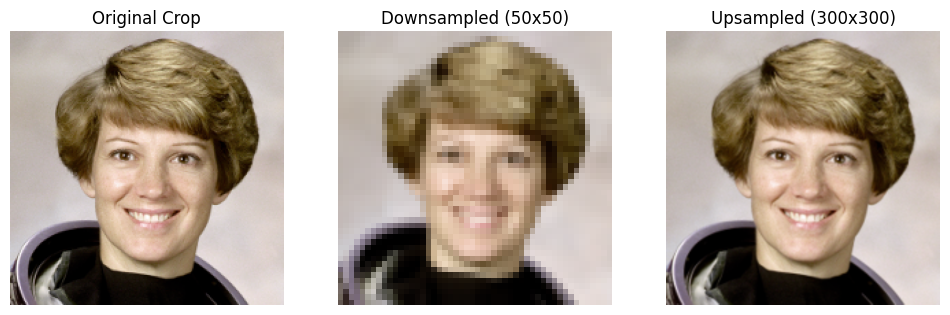

In [13]:

# Downsample to 50x50 pixels
resized_small = transform.resize(crop,(50,50), anti_aliasing=True)

# Upsample to 300x300 pixels
resized_large = transform.resize(crop, (300,300), anti_aliasing=True)


# --- Display original crop and resized versions side by side ---
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(crop)                 # original crop
axes[0].set_title("Original Crop")
axes[0].axis("off")

axes[1].imshow(resized_small)        # downsampled version
axes[1].set_title("Downsampled (50x50)")
axes[1].axis("off")

axes[2].imshow(resized_large)        # upsampled version
axes[2].set_title("Upsampled (300x300)")
axes[2].axis("off")

plt.show()

## E. Mini "Vision Pipeline" ##

In many computer vision tasks, images are processed through a **sequence of steps** called a pipeline.  
Here we demonstrate a **mini pipeline** that performs:  
1. Cropping a region of interest (ROI)  
2. Converting to grayscale  
3. Enhancing contrast with histogram equalization  
4. Resizing to a standard size  

This illustrates how preprocessing steps can be chained to prepare images for analysis or modeling.


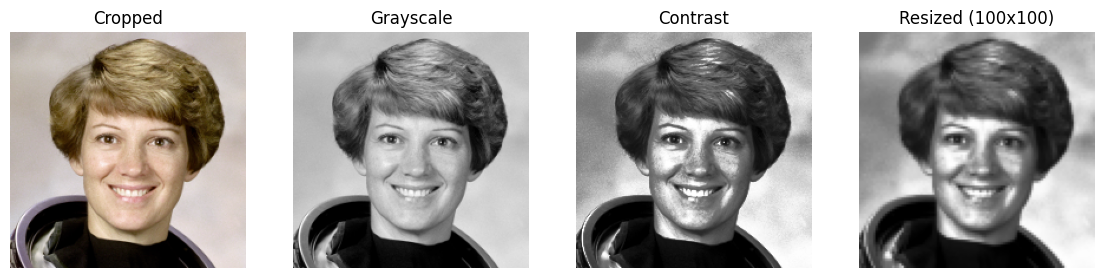

In [14]:
def vision_pipeline(input_img, crop_coords=(10,210,120,320), resize_shape=(100,100)):
    """
    Mini vision pipeline: crop -> grayscale -> contrast -> resize
    """
    assert input_img.shape[2] == 3, "The input image must have 3 channels"
    
    
    # --- Crop the region of interest ---
    img_crop = img[crop_coords[0]:crop_coords[1], crop_coords[2]:crop_coords[3]]
    
    # --- Convert cropped image to grayscale ---
    img_gray = color.rgb2gray(img_crop)
    
    # --- Enhance contrast using histogram equalization ---
    img_contrast = exposure.equalize_hist(img_gray)
    
    # --- Resize the image to a standard size ---
    img_resized = transform.resize(img_contrast, resize_shape)
    
    
    return img_crop, img_gray, img_contrast, img_resized

# --- Apply the pipeline to the image ---
crop, gray, contrast, resized = vision_pipeline(img)

# --- Visualize each stage of the pipeline ---
fig, axes = plt.subplots(1, 4, figsize=(14, 4))
titles = ["Cropped", "Grayscale", "Contrast", "Resized (100x100)"]

for ax, out_img, title in zip(axes, [crop, gray, contrast, resized], titles):
    ax.imshow(out_img, cmap="gray" if out_img.ndim == 2 else None)
    ax.set_title(title)
    ax.axis("off")

plt.show()

## F. Vintage Sepia Filter ##

Implement an Instagram image filter to transform image into vintage sepia with vignetting. Instagram-style filters often combine multiple simple transformations to create a "mood" or style. Here we implement a **vintage filter** that applies:  
1. **Sepia toning** to give a warm, old-photograph effect  
2. **Vignette** to darken edges and focus attention on the center  

This demonstrates how chaining manipulations can produce creative visual effects.


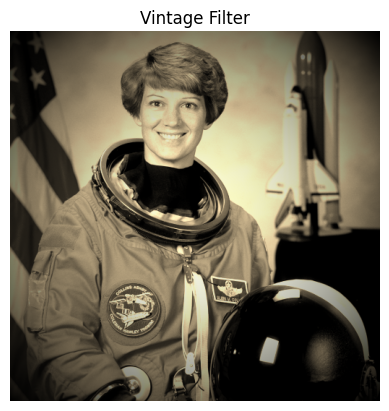

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define the vintage filter function ---
def vintage_filter(input_img):
    assert input_img.shape[2] == 3, "The input image must have 3 channels"
    
    # Convert image to float for accurate computation
    img_f = input_img.astype(np.float32) / 255.0
    
    # Sepia filter matrix
    sepia_filter = np.array([[0.393, 0.769, 0.189],
                             [0.349, 0.686, 0.168],
                             [0.272, 0.534, 0.131]])
    
    # Apply the sepia filter (matrix multiplication for RGB channels)
    sepia = np.dot(img_f, sepia_filter.T)
    sepia = np.clip(sepia, 0, 1)  
    
    # --- Create a vignette mask ---
    rows, cols = sepia.shape[:2]
    
    # Create coordinate grids: 
    # y is a column vector of row indices, x is a row vector of column indices
    y, x = np.ogrid[0:rows, 0:cols]
    
    # Define the center of the image (row midpoint, col midpoint)
    center = (rows/2, cols/2)
    
    # Compute the Euclidean distance of each pixel from the center
    dist = np.sqrt((x-center[1])**2 + (y-center[0])**2)
    
    # Normalize distances to [0, 1] by dividing by the maximum distance (corner pixels)
    mask = dist / dist.max()
    
    vignette = 1-mask**2 # stronger darkening toward edges
    vignette = np.clip(vignette, 0, 1)
    
    # Apply vignette to sepia image
    sepia_vignette = sepia*vignette[:, :, np.newaxis]
    
    # Convert back to 8-bit image
    return (sepia_vignette * 255).astype(np.uint8)

# --- Apply the vintage filter and display ---
plt.imshow(vintage_filter(img))
plt.title("Vintage Filter")
plt.axis("off")
plt.show()

## G. Cool Blue Film Filter ##

Implement an Instagram image filter to transform image into Cool Blue Film style. Another popular Instagram-style effect is a **cool-toned cinematic look**.  

This filter combines:  
1. **Color shift** to reduce reds and enhance blues  
2. **Brightness/contrast adjustment** to improve overall tone  
3. **Soft Gaussian blur** to give a dreamy, cinematic feel  

It demonstrates how chaining multiple simple manipulations can create a visually appealing style.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1631370399190921].


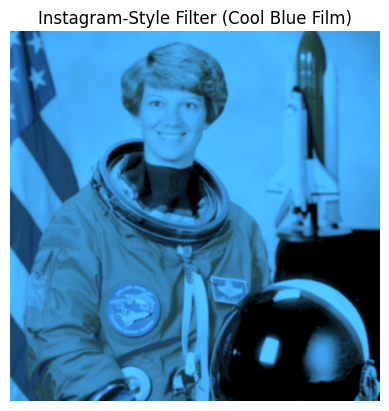

In [16]:
import numpy as np
from skimage import exposure, img_as_float, filters
import matplotlib.pyplot as plt

# --- Define the Cool Blue Film filter function ---
def cool_blue_filter(input_img):
    assert input_img.shape[2] == 3, "The input image must have 3 channels"
    
    # Convert image to float in [0, 1] range for accurate computation
    f_img = img_as_float(input_img)

    # --- Step 1: Cool color shift ---
    cool = f_img.copy()
    
    cool[..., 0] = cool[..., 0]*0   # reduce red
    cool[..., 2] = cool[..., 2]*2   # boost blue

    # --- Step 2: Brightness/contrast adjustment ---
    bright = exposure.adjust_gamma(cool, gamma=0.4)

    # --- Step 3: Apply soft Gaussian blur for dreamy effect ---
    blurred = filters.gaussian(bright)

    return blurred

# --- Apply the filter ---
filtered_cool = cool_blue_filter(img)

# --- Display the filtered image ---
plt.imshow(filtered_cool)
plt.title("Instagram-Style Filter (Cool Blue Film)")
plt.axis("off")
plt.show()